# 10.Azure ML SDKの概要

## Azure Machine Learning ワークスペース

ワークスペースは、機械学習ワークロードに関連付けられた実験、データ、コンピューティング先およびその他の資産のコンテキスト。

### Machine Learning資産用のワークスペース

ワークスペースは、関連する一連の機械学習リソースの境界を定義するもの。  
ワークスペースを使用することで、プロジェクト、デプロイ環境(テストと運用など)、チーム、またはその他の編成の原則に基づいて機械学習リソースをグループ化できる。

ワークスペース内には以下の資産がある。

- 開発、トレーニング、デプロイのためのコンピューティング先
- 実験及びモデルトレーニング用のデータ
- 共有コードとドキュメントを含むノートブック
- 実験(履歴、ログに記録されたメトリック、出力含む)
- トレーニング済みのモデル

### Azureリソースとしてのワークスペース

ワークスペースはAzureリソースなので、ワークスペースをsupportするために必要なその他の関連するAzureリソースとともに、  
Azureサブスクリプションのリソースグループ内に定義される。

ワークスペースとともに作成されるAzureリソースは次のものがある。

- ストレージアカウント
    - ワークスペースで使用されるファイルと、実験およびモデルトレーニング用のデータを格納するために使用される
- Application Insights
    - ワークスペース内で予測サービスを監視するために使用される
- Azure Key Vault
    - ワークスペースで使用される認証キーや資格情報などのシークレットを管理するために使用される
- コンテナーレジストリ
    - デプロイされたモデルのコンテナーを管理するために必要に応じて作成される

### ロールベースのアクセス制御

ワークスペースにはロールベースの承認ポリシーを割り当てることができる。  
これにより、特定のAzure Active Directoryプリンシパルが実行できるアクションを制限するアクセス許可を管理できる。

### ワークスペースの作成

以下の方法でワークスペースを作成できる。

- Azureポータルで、サブスクリプション、リソースグループ、ワークスペース名を指定して、新しいMachine Learningリソースを作成。
- Azure ML Python SDKを使用して、ワークスペースを作成するコードを実行する。  
たとえば、次のコードによって`aml-workspace`という名前のワークスペースが作成される。  
※Azure ML SDK for Pythonがインストールされ、有効なサブスクリプションIDが指定されていることを前提としている。

```
from azureml.core import Workspace
    
    ws = Workspace.create(name='aml-workspace', 
                      subscription_id='123456-abc-123...',
                      resource_group='aml-resources',
                      create_resource_group=True,
                      location='eastus'
                     )
```

In [1]:
from azureml.core import Workspace
    
ws_1 = Workspace.create(name='mslearn-20210613b', 
                      subscription_id='153404fd-72ab-4092-b50e-de490c5509fc',
                      resource_group='20210613',
                      create_resource_group=True,
                      location='eastus'
                     )

Deploying AppInsights with name mslearn2insights324fbe57.
Deployed AppInsights with name mslearn2insights324fbe57. Took 2.4 seconds.
Deploying StorageAccount with name mslearn2storage644e4d66e.
Deploying KeyVault with name mslearn2keyvault60366ceb.
Deployed KeyVault with name mslearn2keyvault60366ceb. Took 17.26 seconds.
Deployed StorageAccount with name mslearn2storage644e4d66e. Took 21.62 seconds.
Deploying Workspace with name mslearn-20210613b.
Deployed Workspace with name mslearn-20210613b. Took 22.54 seconds.


- Azure ML CLI拡張機能を含むAzure CLIを使用する。  
例えば次のコマンドを使用できる　※aml-resourcesという名前のリソースグループが既に作成されていることを前提としてる

```
az ml workspace create -w 'aml-workspace' -g 'aml-resources'
```

- Azure Resource Managerテンプレートを使用する。

# 演習 - ワークスペースを作成する

1. Azureポータルで、新しいMLリソースを作成する。

    - サブスクリプション
    - リソースグループ
    - ワークスペース名
    - リージョン
    - ストレージアカウント
    - Key vault
    - アプリケーション insights
    - コンテナーレジストリ

※注:Azure MLワークスペースを作成する際には、高度なオプションを使用してプライベートエンドポイントを介したアクセスを制御したり、  
データ暗号化のカスタムキーを指定したりすることができる。

2. ワークスペースとその関連リソースが作成されたら、ポータルでワークスペースを表示する。

## Azure ML Studioを見る

Azure MLスタジオでは、ワークスペースを操作するための専用Webポータルを提供している。  
スタジオを起動することで、Azure MLスタジオへ移動することができ、ワークスペースのリソースを管理することができる。

## コンピューティングインスタンスの作成

Azure MLのメリットの一つは、実験やトレーニングスクリプトを大規模に実行できるクラウドベースのコンピューティングを作成できること。

1. **コンピューティング**を表示する。  
ここでは、データサイエンス活動のためのコンピューティングリソースを管理する。作成できるリソースは4種類

    - **コンピューティングインスタンス**
        - データサイエンティストがデータやモデルを扱うために使用する開発ワークステーション
    - **コンピューティングクラスター**
        - 実行コードをオンデマンドに処理するためのスケーラブルな仮想マシンのクラスター
    - **推論クラスター**
        - 訓練されたモデルを使用する予測サービスの導入対象
    - **アタッチされたコンピューティング**
        - 他のAzureコンピューティングリソースへのリンク  
        Virtual MachineやAzure Databricksクラスターなど、他のAzureコンピューティングへのリンク

2. コンピューティングインスタンスより、新しいコンピューティングインスタンスを追加する。  
このインスタンスは、ノートブックでコードを実行するためのワークステーションとして使用する。

3. コンピューティングが作成されるまで待つ。


## ノートブックのクローンおよび実行

データサイエンスや機械学習の実験の多くは、ノートブックでコードを実行することで行われる。  
あなたのコンピューティングインスタンスには、広範な作業に使用できる全機能のPythonノートブック環境が含まれているが、  
基本的なノートブックの編集には、Azure MLスタジオの組み込みノートブックページを使用できる。

1. Azure MLスタジオで**Notebooks**を開く

2. ターミナルを開き、`git`コマンドでノートブックのクローンを取得する

3. ターミナルを閉じ、ファイルペイン上で更新してからノートブックを選択することで、ノートブックを開くことができる。

# Azure Machine Learningでノートブックを始める

Azure Machine Learningは機械学習を作成・管理するためのクラウドサービスで、  
データサイエンスや機械学習の作業の多くは、このようなノートブックで実現できる。

## Azure ML Python SDK

このケースでは、Azure MLコンピューティングインスタンス上のConda環境でノートブックを実行している。  
この環境はデフォルトでコンピューティングインスタンスにPythonパッケージがインストールされており、  
データサイエンティストが通常使用する一般的なPythonパッケージが含まれている。

また、Azure ML Python SDKも含まれており、これはAzure MLワークスペースのリソースを使用するコードを書くことができるPythonパッケージである。

以下のセルを実行して、`azureml-core`パッケージをインポートし、インストールされているSDKのバージョンを確認する。

In [1]:
import azureml.core

print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.28.0


## ワークスペースの接続

すべての実験と関連するリソースは、Azure MLのワークスペース内で管理される。  
既存のワークスペースに接続するか、Azure ML SDKを使用して新しいワークスペースを作成することができる。

ほとんどの場合、ワークスペースの接続情報JSONファイルに保存する必要がある。
これにより、AzureのサブスクリプションIDなどの詳細を覚えておく必要がなく、簡単に接続することができる。

JSONファイルは、Azureポータルのワークスペース用ブレード、またはAzure MLスタジオのワークスペース詳細ペインからダウンロードできるが、  
ワークスペース内でコンピューティングインスタンスを使用している場合は、構成ファイルはすでにルートフォルダにダウンロードされている。

以下のコードは、設定ファイルを使用してワークスペースに接続している。  
> 注:ノーツブックセッションでワークスペースに初めて接続した時、Azureにサインインするように促されることがある。  
サインインに成功したら、開いていたブラウザタブを閉じ、このノートブックに戻ることができる。

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, "loaded")

20210613 loaded


## ワークスペースでAzure MLリソースを表示する

ワークスペースの接続ができたので、リソースを扱うことができる。  
例えば、以下のコードを使用して、ワークスペースのコンピューティングリソースを列挙することができる。

In [3]:
print("Compute Resources:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)

Compute Resources:
	 mslearn-20210613a : ComputeInstance


## Azure MLのツールとインターフェイス

Azure MLにはクラウドベースのサービスが用意されており、その使用方法には柔軟性がある。  
Azure ML用に特別に設計されたユーザインターフェイスがある。  
また、プログラムインターフェイスを使用してワークスペースリソースを管理したり、機械学習の操作を実行したりすることができる。


### Azure MLスタジオ

Azure MLワークスペース内の資産をAzureポータル上で管理できるが、  
これはAzureのすべての種類のリソースを管理するための一般的なインターフェイスであるため、データ分析に関連するその他のユーザは、  
より焦点を絞った専用インターフェイスの使用を推奨。

Azure MLスタジオは、Azure MLワークスペースを管理するためのWebベースツールで、  
これを使用してワークスペース内のすべての資産を作成、管理、表示できる。また、次のグラフィカルツールが用意されている。

- デザイナー
    - コードなしの機械学習モデル開発のためのインターフェイス
- 自動機械学習
    - データに対して最適なモデルを見つけるため、アルゴリズムとデータ前処理手法を組み合わせて使用しモデルをトレーニングできる  
    ウィザードインターフェイス

### Azure ML SDK
Azure MLスタジオのようなグラフィカルインターフェイスを使用すると、機械学習資産を簡単に作成および管理できるが、  
多くの場合、リソースの管理にコードベースのアプローチを使用すると便利で、管理するためのスクリプトを記述することで、次のことができる。

- 好みの開発環境から機械学習を実行できる
- リソースの作成と構成を自動化し、反復可能にする
- 複数の環境(開発、テスト、運用など)でレプリケートする必要があるリソースの一貫性を確保する
- 継続的インテグレーション/継続的デプロイ(CI/CD)パイプラインなどの開発者の運用(DevOps)ワークフローに機械学習のリソース構成を組み込むことができる。

Azure MLにより、Azure MLワークスペースでリソースを作成、管理、使用するために使用できる、PythonおよびR用のソフトウェア開発キット(SDK)が提供される。

### Azure ML SDK for Pythonのインストール

`pip`コマンドを用いて、以下のようにインストールできる。

```
pip install azureml-sdk
```
SDKはPython pipユーティリティを使用してインストールされ、メインの**azureml-sdk**パッケージと、特殊な昨日を含む多くの補助的なパッケージで構成される。  
例えば、**azureml-widgets**パッケージでは、jupyter notebook環境で対話型ウィジェットのサポートが提供される。


### ワークスペースへの接続

SDKパッケージをpython環境にインストールできたら、ワークスペースに接続して機械学習の操作を実行するためのコードを記述できる。  
ワークスペースに接続する最も簡単な方法は、以下のようにAzureサブスク、リソースグループ、ワークスペースの詳細を含むワークスペース構成ファイルを使用すること。

> ※以下のjsonファイルは、概要ページからダウンロードしたもの

```:json
{
    "id": "/subscriptions/153404fd-72ab-4092-b50e-de490c5509fc/resourceGroups/20210613/providers/Microsoft.MachineLearningServices/workspaces/20210613",
    "name": "20210613",
    "type": "Microsoft.MachineLearningServices/workspaces",
    "location": "westus2",
    "tags": {},
    "etag": null,
    "properties": {
        "friendlyName": "20210613",
        "description": "",
        "storageAccount": "/subscriptions/153404fd-72ab-4092-b50e-de490c5509fc/resourcegroups/20210613/providers/microsoft.storage/storageaccounts/202106138491592323",
        "containerRegistry": "",
        "keyVault": "/subscriptions/153404fd-72ab-4092-b50e-de490c5509fc/resourcegroups/20210613/providers/microsoft.keyvault/vaults/a202106137570553126",
        "applicationInsights": "/subscriptions/153404fd-72ab-4092-b50e-de490c5509fc/resourcegroups/20210613/providers/microsoft.insights/components/202106137897442529",
        "hbiWorkspace": false,
        "tenantId": "5456e8d8-0223-4619-ba5b-e313627da53d",
        "imageBuildCompute": "",
        "provisioningState": "Succeeded",
        "creationTime": "2021-06-13T08:30:48.5558351+00:00",
        "notebookInfo": {
            "resourceId": "ed8e6e4a20b24598986771c9c7468e34",
            "fqdn": "ml-20210613-westus2-322f90dd-b503-46f1-8d45-68f1641a9197.notebooks.azure.net",
            "isPrivateLinkEnabled": false,
            "notebookPreparationError": null
        },
        "storageHnsEnabled": false,
        "workspaceId": "322f90dd-b503-46f1-8d45-68f1641a9197",
        "linkedModelInventoryArmId": null,
        "privateLinkCount": 0,
        "allowPublicAccessWhenBehindVnet": false,
        "discoveryUrl": "https://westus2.api.azureml.ms/discovery",
        "sdkTelemetryAppInsightsKey": "19f24253-9564-406c-9a1e-a48a21b145aa"
    },
    "identity": {
        "type": "SystemAssigned",
        "principalId": "18459ee1-c609-4ff2-98c6-ad94eb5ac6c1",
        "tenantId": "5456e8d8-0223-4619-ba5b-e313627da53d"
    },
    "sku": {
        "name": "Basic",
        "tier": "Basic"
    },
    "systemData": {
        "createdAt": "2021-06-13T08:30:45.1488264Z",
        "createdBy": "tsutayan@gmail.com",
        "createdByType": "User",
        "lastModifiedAt": "2021-06-13T08:30:45.1488264Z",
        "lastModifiedBy": "tsutayan@gmail.com",
        "lastModifiedByType": "User"
    }
}
```

構成ファイルを使用してワークスペースに接続するには、以下のようにSDKの**Workspace**クラスの**from_config**メソッドを使用できる。

```
from azureml.core import Workspace

ws = Workspace.from_config()
```

限定では、**from_config**メソッドより、Pythonコードファイルが格納されているフォルダで**config.json**が検索されるが、  
必要に応じて別のファイルパスを指定することができる。

構成ファイルを使用する代わりに、以下のように明示的に指定されたサブスクリプション、リソースグループ、ワークスペースの詳細を使用して、  
**Workspace**クラスの**get**メソッドを使用することもできる。  
ただし、複数のスクリプトを使用する場合の柔軟性が高いため、一般的には構成ファイルの手法が推奨される。

```
from azureml.core import Workspace

ws = Workspace.get(name='aml-workspace',
                   subscription_id='1234567-abcde-890-fgh...',
                   resource_group='aml-resources')
```

どちらの方法を使用する場合でも、Azureサブスクリプションに現在アクティブなセッションがない場合は、認証を求めるメッセージが表示される。

### Workspaceクラスの使用

**Workspace**クラスは、ほとんどのコード処理の開始点となる。  
たとえば、以下のように**compute_targets**属性を使用して、ワークスペースに定義されているコンピューティング先を含む辞書オブジェクトを取得できる。

```
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print(compute.name, ":", compute.type)
```

SDKには、Azure MLワークスペースで多くの種類のリソースを作成、管理、使用するために使える、充実したクラスライブラリが含まれる。

※SDKドキュメント:https://aka.ms/AA70zeq

### Azure ML CLI拡張機能

Azure CLIは、Azureリソースを管理するためのクロスプラットフォームコマンドラインツール。  
Azure ML CLI拡張機能をインストールするには、最初にAzure CLIをインストールする必要がある。

```
az extension add -n azure-cli-ml
```

Azure ML CLI拡張機能を使用するには、実行するアクションに対して適切なパラメータを指定した`azml`コマンドを実行する。  
たとえば、ワークスペース内のコンピューティング先を一覧表示するには、次のコマンドを実行する。

> 注: 以下では、`-g`によって、`-w`で定義されたAzure MLワークスペースが指定されているリソースグループ名を指定する。

```
az ml computetarget list -g 'aml-resources' -w 'aml-workspace'
```

### コンピューティングインスタンス

Azure MLには、ワークスペース内に**コンピューティングインスタンス**を作成することで、  
そのワークスペース内の他のすべてのリソースとともに管理される開発環境を提供する機能が含まれている。

コンピューティングインスタンスには、Jupyter notebookとJupyterLabのインストールが含まれる。  
このインストールを使用すると、Azure ML　SDKを使用してワークスペース内のリソースを操作するコードを記述して実行できる。

コンピューティングインスタンスは、Azureでホストされているため、料金はコンピューティングリソースが実行中のときだけ発生する。  
そのため、必要に応じてコンピューティングインスタンスを作成し、ワークロードが完了したら**これを停止することでコストを最小限に抑える**ことができる。

### Visual Studio Code

VSCodeは簡易コード編集環境であり、さまざまな種類のコード用のビジュアルインターフェイスが提供される。  
また、JSONやXMLなどの一般的なデータ形式用のIntelliSenceと構文の書式設定も使用できる。

VSCodeの柔軟性は、特定のワークロードに対する構文チェック、デバッグ、ビジュアル管理インターフェイスを追加する、  
モジュール系s機の拡張機能をインストールできることに基づく。

VSCおで用のAzure ML拡張機能により、Azure MLワークスペース内のリソースを操作するためのグラフィカルインターフェイスが提供される。  
Azure MLの機能と、Pythonの拡張機能を組み合わせて、Visual Studio Code環境からAzure MLで完全なエンドツーエンドの機械学習ワークロードを管理できる。

## Azure MLの実験

Azure MLにおいて、**実験とは名前付きプロセス**であり、通常は、メトリックと出力を生成し、  
Azure MLワークスペースで追跡できることが可能なスクリプトまたはパイプラインを実行することである。

実験は、様々なデータ、コード、設定を使用して複数回実行できる。  
各実行が、Azure MLで追跡されるため、実行履歴を表示して、各実行の結果を比較できる。

### 実験の実行コンテキスト

実験を送信する場合、以下のように**実験の実行コンテキスト**を使用して、Azure MLで追跡される実験の実行を初期化し、終了する。

```
from azureml.core import Experiment

# 実験変数の作成
experiment = Experiment(workspace = ws, name = &quot;my-experiment")

# 実験の開始
run = experiment.start_logging()

# 実験コードをここに入れる

# 実験の終了
run.complete()
```

実験が完了したら、Azure MLスタジオの**実験**タブで実行の詳細を確認できる。

### メトリックのログ記録と出力の作成

実験が最も役立つのは、複数回の実行にまたがって追跡できるメトリックと出力を生成する場合。

#### メトリックのログ記録

すべての実験でログファイルが生成される。  
ログファイルには、対話形式での実験中に端末に書き込まれるメッセージが含まれているため、簡単な`print`ステートメントを使用し、  
ログにメッセージを書き込むことができる。
ただし、実行を繰り返して比較するために名前付きメトリックを記録する場合は、この目的に特化したさまざまなログ記録関数が用意されている**Run**オブジェクトを使用する。  
以下に例を示す。

- log
    - 1つの名前付きの値を記録
- log_list
    - 値の名前付きリストを記録
- log_row
    - 複数の列を含む行を記録
- log_table
    - 辞書をテーブルとして記録
- log_image
    - 画像ファイルまたはプロットを記録

例えば、次のコードでは、CSVファイル内の観測(レコード)の数が記録される。

```
from azureml.core import Experiment
import pandas as pd

# ワークスペースでAzureの実験を行う
experiment = Experiment(workspace = ws, name = 'my-experiment')

# 実験データの記録開始
run = experiment.start_logging()

# データセットの読み込みと行数のカウント
data = pd.read_csv('data.csv')
row_count = (len(data))

# 行数をロギング
run.log('observations', row_count)

# 実験の終了
run.complete()
```

#### ログに記録されたメトリックの取得と表示

次に示すように、Azure MLスタジオでの実験の実行によって、またはノートブックで**RunDetails**ウィジェットを使用することによって、  
ログに記録されたメトリックを表示できる。

```
from azureml.widgets import RunDetails

RunDetails(run).show()
```

以下のように**Run**オブジェクトの**get_metrics**メソッドを使用してメトリックを取得することもできる。  
このメソッドではメトリックのJSON表現が返される。

```
import json

# Get logged metrics
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))
```

前のコードでは、次のような出力が生成される場合がある。

```
{
  "observations": 15000
}
```

#### 実験の出力ファイル

実験ではメトリックをログに記録するだけでなく、出力ファイルも生成できる。  
多くの場合、これらはトレーニング済みの機械学習モデルだが、任意の種類のファイルを保存し、実験の実行の出力として使用可能にすることができる。  
実験の出力ファイルは、実験の**outputs**フォルダに保存される。

実験の出力にファイルを追加するために使用する手法は、実験を実行する方法によって異なる。  
これまでの例では、実験のライフサイクルをコードのインラインで制御している。  
この方法を使用すると、次に示すように、実験コード内の**Run**オブジェクトの**upload_file**メソッドを使用して、  
ローカルファイルを実行の**outputs**フォルダーにアップロードできる。

```
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')
```

リモートコンピューティングコンテキストで実験を実行する場合、そのコンピューティングコンテキストで**output**フォルダに書き込まれたファイルは、  
実験が完了すると、実行の**outputs**フォルダーに自動的にアップロードされる。

実験の実行にどの方法を使用しても、次のように**Run**オブジェクトから出力ファイルの一覧を取得できる。

```
import json

files = run.get_file_names()
print(json.dumps(files, indent=2))
```

前のコードでは、次のような出力が生成される場合がある。

```
[
  "outputs/sample.csv"
]
```

#### 実験としてスクリプトの実行

**Experiment**オブジェクトの**start_logging**メソッドを使用して、実験をインラインで実行できるが、  
実験のロジックをスクリプト内にカプセル化し、そのスクリプトを実験として実行するほうが一般的。  
そのスクリプトは任意の有効なコンピューティングコンテキストで実行できるため、大規模に実験を実行するためのより柔軟なソリューションになる。

実験スクリプトは、実験で実行するコードを含むPythonコードファイルに過ぎない。  
実験の実行コンテキスト(メトリックをログに記録するために必要)にアクセスするには、スクリプトで**azureml.core.Run**をインポートし、  
**get_context**メソッドを呼び出す必要がある。  
その後、次の例に示すように、スクリプトで実行コンテキストを使用してメトリックをログに記録し、ファイルをアップロードし、実験を完了することができる。

```
from azureml.core import Run
import pandas as pd
import matplotlib.pyplot as plt
import os

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
data = pd.read_csv('data.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)

# Save a sample of the data
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()
```

スクリプトを実験として実行するには、実行するスクリプトとそれを実行するPython環境を定義する**スクリプト構成**を定義する必要がある。  
これは、**ScriptRunConfig**オブジェクトを使用して実装される。

例えば、次のコードを使用して、**experiment_files**フォルダー内のスクリプトに基づいて実験を実行することができる。

> 注:このフォルダーには、前述のスクリプトコード例の`data.csv`など、スクリプトで使用するファイルも含まれている必要がある。

```
from azureml.core import Experiment, ScriptRunConfig

# スクリプト構成の作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='experiment.py') 

# 実験の実行
experiment = Experiment(workspace = ws, name = 'my-experiment')
run = experiment.submit(config=script_config)
run.wait_for_completion(show_output=True)
```

> 注:暗黙的に作成された**RunConfiguration**オブジェクトにより、スクリプトで使用可能なパッケージを含む、実験用のPython環境が定義される。  
スクリプトが規定の環境に含まれていないパッケージに依存している場合は、必要なPythonパッケージを指定するために、**CondaDependencies**オブジェクトを使用する**Environment**オブジェクトに**ScriptRunConfig**を関連付ける必要がある。  

## 演習 - 実験を実行する

この演習では、Azure ML SDKを使用して、Pythonコードを実験として実行する。

### Azure ML SDKがインストールされていることを確認する

Azure ML SDKは、コンピューティングインスタンスにデフォルトでインストールされている。  
以下の手順でインストールを確認できる。

In [2]:
!pip show azureml-sdk

Name: azureml-sdk
Version: 1.28.0
Summary: Microsoft Azure Machine Learning Python SDK
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: azureml-train, azureml-train-automl-client, azureml-pipeline, azureml-core, azureml-dataset-runtime
Required-by: 


Azure ML SDKパッケージは、Azure MLを使用するために必要な最も重要なライブラリを提供している。  
しかし、メインのSDKに含まれていない追加パッケージもある。  
以下のように、ノートブックにAzure MLの情報を表示するためのライブラリを含む**azureml-widgets**パッケージもインストールされていることを確認する。

In [3]:
!pip show azureml-widgets

Name: azureml-widgets
Version: 1.28.0
Summary: azureml widgets
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: ipywidgets, azureml-core, azureml-telemetry, azure-storage-blob
Required-by: 


## 実験を行う

Azure ML SDKを使用すると、メトリックを記録して出力を生成するコード実験を実行できる。  
これは、Azure MLでのほとんどの機械学習操作の中核となるもの。

### ワークスペースの接続

すべての実験と関連するリソースは、Azure MLのワークスペース内で管理される。  
殆どの場合、ワークスペースの構成をjsonファイルに保存する必要がある。  
これにより、AzureサブスクリプションIDなどの詳細を覚えておく必要がなく、簡単に再接続することができる。  
jsonファイルは、Azureポータルのワークスペース用ブレードからダウンロードできるが、ワークスペース内でコンピューティングインスタンスを使用している場合は、  
構成ファイルは既にルートフォルダにダウンロードされている。

以下のコードは、構成ファイルを使用してワークスペースに接続する。

> 注:Azureサブスクリプションで認証済みのセッションをまだ確立していない場合、リンクをクリックして認証コードを入力し、  
Azureにサインインすることで認証するように促される。

In [4]:
import azureml.core
from azureml.core import Workspace

# 保存した設定ファイルよりワークスペースを読み込む
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with 20210613


### 実験の実行

ここでは、Azure ML実験を使ってPythonコードを実行し、データから抽出した値を記録する方法を学ぶ。  
このケースでは、糖尿病の検査を受けた患者の詳細を含む単純なデータセットを使用する。  
実験を実行してデータを探索し、統計、視覚化、データサンプルを抽出する。

使用するコードの殆どはデータ探索プロセスで実行されるようなごく一般的なPythonコードだが、  
いくつかの行を追加することで、コードはAzure MLの実験を使用し、実行の詳細を記録する。

In [6]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# ワークスペース内にAzureMLの実験を作成する
experiment = Experiment(workspace=ws, name="mslearn-diabetes")

In [7]:
# 実験データのロギングを開始し、実験実行のリファレンスを取得
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

Starting experiment: mslearn-diabetes


In [8]:
# ローカルデータよりデータを読み込む
data = pd.read_csv('data/diabetes.csv')

In [9]:
# 行をカウントし、結果を記録
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

Analyzing 10000 rows of data


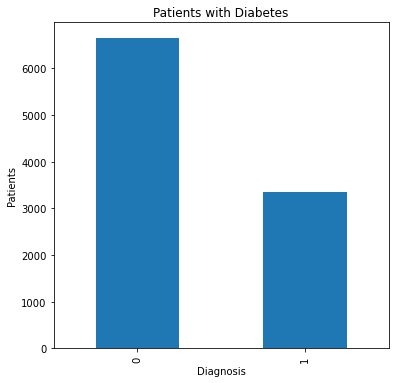

In [10]:
# 糖尿病患者と非糖尿病患者の数をプロットしてロギング
diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name='label distribution', plot=fig)

In [11]:
# 別々に妊娠数を記録する
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

In [12]:
# 数値列の要約統計を記録
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat=keys[index], value = values[index])

In [13]:
# データのサンプルを保存し、実験の出力にアップロード
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

In [15]:
# 実験の終了
run.complete()

### 実行の詳細を参照する

ノートブックでは、**RunDetails**ウィジェットを用いて実行の詳細を視覚化することができる。

In [18]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

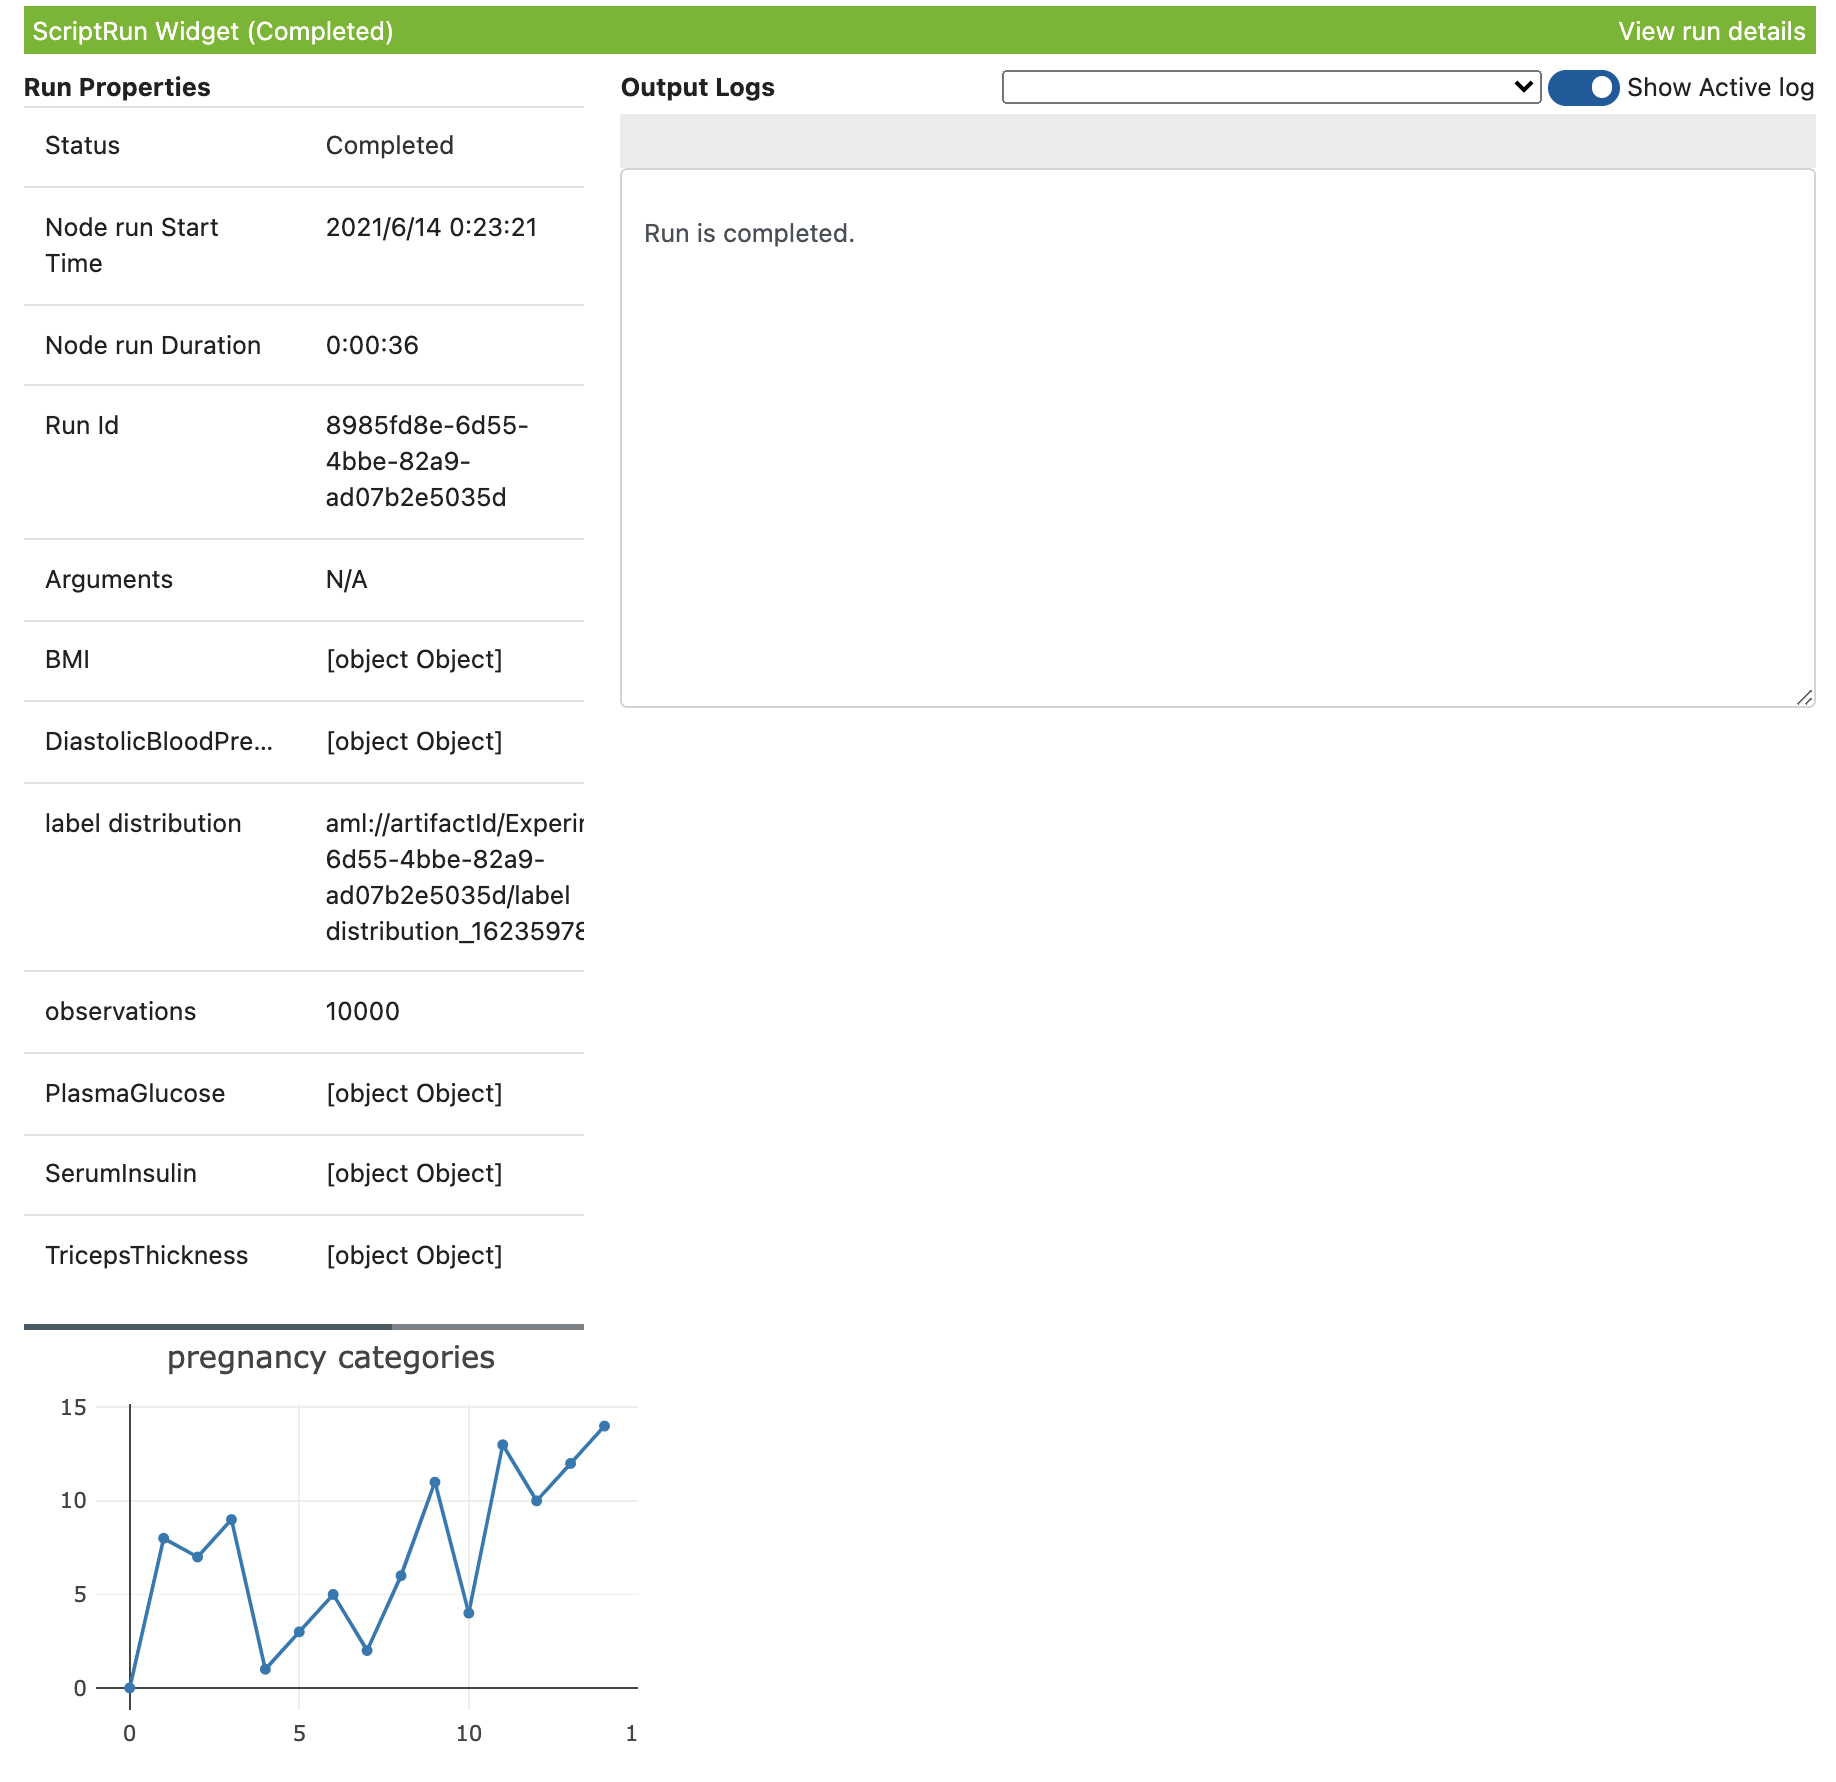

#### Azure MLスタジオで詳細を表示

RunDetailsウィジェットには、右上にある**View run details**をクリックすることで、実行の詳細をスタジオで表示することができる。

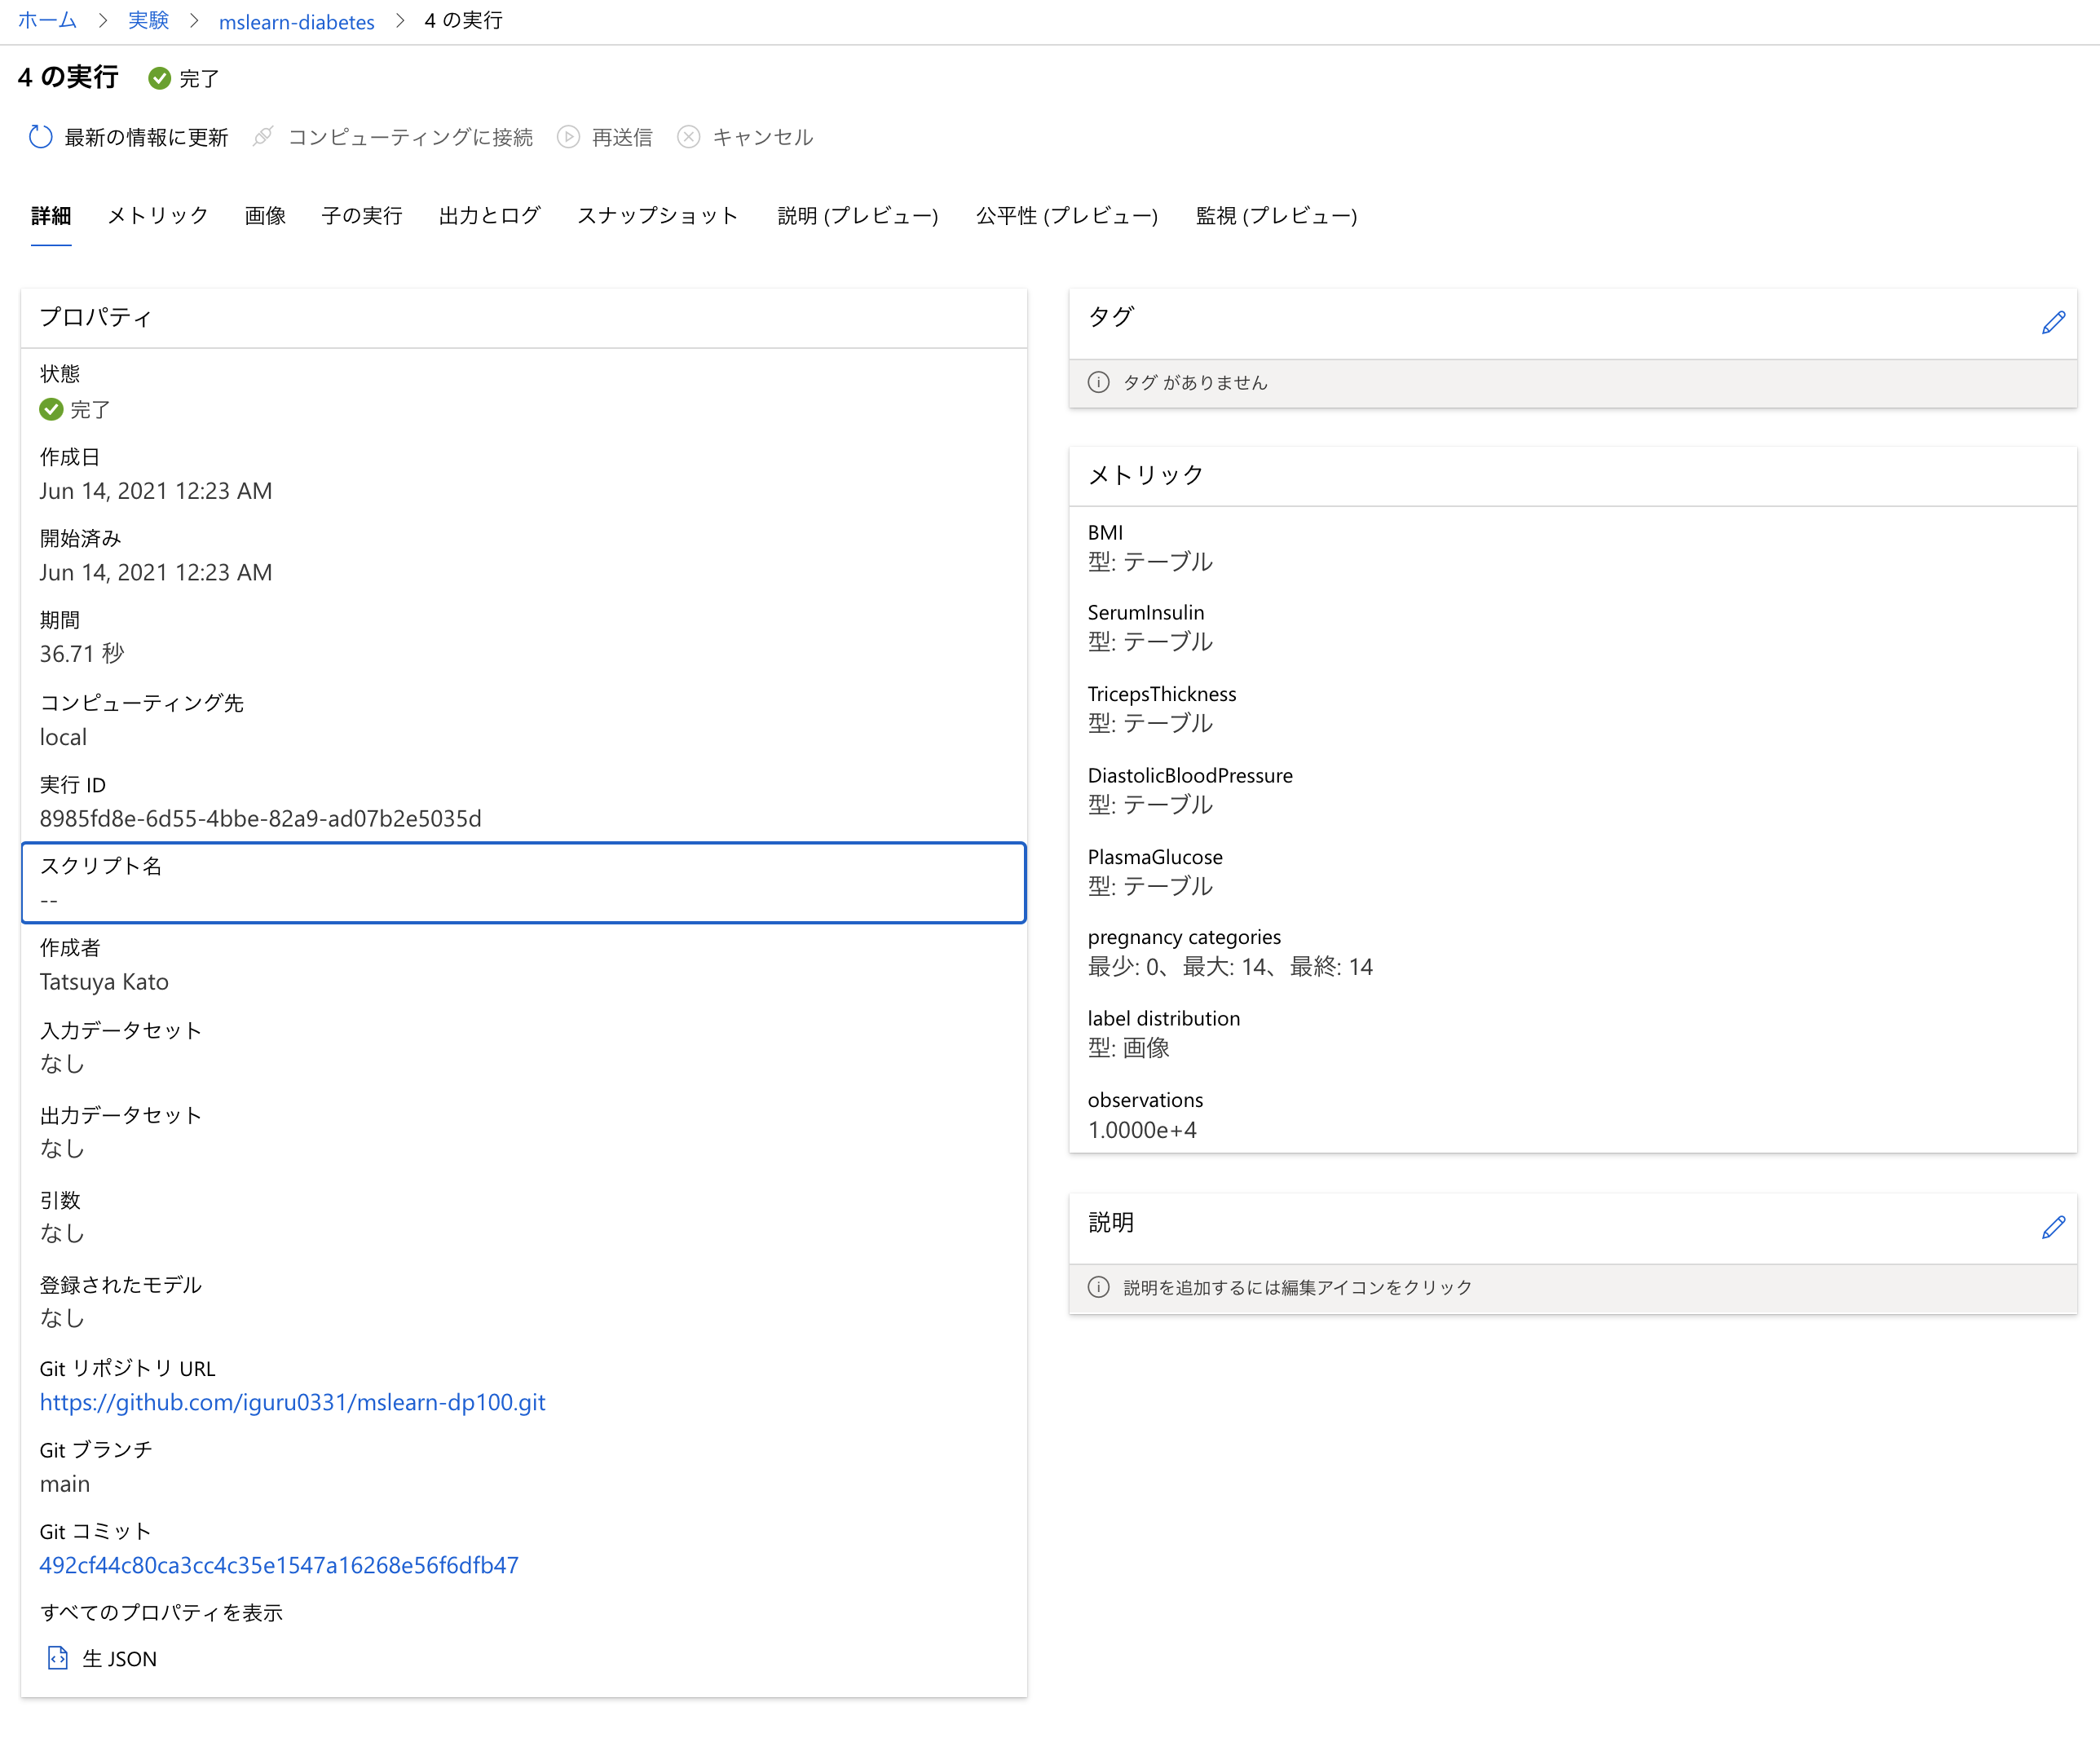

Azure MLスタジオで実行を表示する場合、以下の点に注意すること。

- 詳細タブ
    - 実験実行の一般的なプロパティが含まれている
- メトリックタブ
    - ログに記録されたメトリックを選択し、表やチャートとして表示することができる
- 画像タブ
    - 実験で記録された画像やプロットを選択して表示することができる
- 子の実行タブ
    - 子の実行の一覧を表示する
- 出力とログタブ
    - 実験で生成された出力またはログファイルが表示される
- スナップショットタブ
    - 実験コードが実行されたフォルダ内のすべてのファイルが表示される
        - ここでは、このノートブックと同じフォルダ内のすべてのファイル
- 説明(プレビュー)タブ
    - 実験によって生成されたモデルの説明を表示するために使用する
- 公平性タブ
    - 機械学習モデルの公平性を評価するのに役立つ予測性能の格差を視覚化するために使用する

#### SDKを使って実験の詳細を取得する

前に実行したコードのrun変数は、**Run**オブジェクトのインスタンス。  
これは、Azure MLの実験の個々のRunへの参照であり、これを使用してRunとその出力に関する情報を取得することができる。

In [19]:
import json

# ロギングされたメトリックの取得
print("Metrics:")
metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name, ":", metrics[metric_name])

Metrics:
observations : 10000
label distribution : aml://artifactId/ExperimentRun/dcid.8985fd8e-6d55-4bbe-82a9-ad07b2e5035d/label distribution_1623597819.png
pregnancy categories : [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
PlasmaGlucose : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
DiastolicBloodPressure : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
TricepsThickness : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
SerumInsulin : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465278, 14.0, 39.0, 85.0, 197.0, 796.0]}
BMI : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [1000

In [20]:
# 出力ファイルの取得
print("\nFiles:")
files = run.get_file_names()
for file in files:
    print(file)


Files:
label distribution_1623597819.png
outputs/sample.csv


実験によって生成されたファイルをダウンロードするには、`download_file`メソッドを使って個々にダウンロードするか、  
`download_files`メソッドを使って複数のファイルを取得することができる。  
以下のコードでは、Runの出力フォルダー内のすべてのファイルをダウンロードしている。

In [21]:
import os

download_folder = 'downloaded-files'

# outputフォルダ内のファイルをダウンロード
run.download_files(prefix='outputs', output_directory=download_folder)

# ダウンロードされたことを確認する
for root, directories, filenames in os.walk(download_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

downloaded-files/outputs/sample.csv


実験の実行をトラブルシューティングする必要がある場合、`get_details`メソッドを使用して実行に関する基本的な詳細情報を取得するか、　　
`get_details_with_logs`メソッドを使用して実行の詳細情報と実行中に生成されたログファイルの内容を取得することができる。

In [22]:
run.get_details_with_logs()

{'runId': '8985fd8e-6d55-4bbe-82a9-ad07b2e5035d',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-06-13T15:23:21.653625Z',
 'endTimeUtc': '2021-06-13T15:23:58.360854Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '492cf44c80ca3cc4c35e1547a16268e56f6dfb47',
  'mlflow.source.git.commit': '492cf44c80ca3cc4c35e1547a16268e56f6dfb47',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '5124abea-3f08-46eb-812a-3e42db7a9cbc'},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {},
 'submittedBy': 'Tatsuya Kato'}

なお、この詳細には、実験を実行したコンピュートターゲット、実験を開始した日時、終了した日時などの情報が含まれている。  
また、実験コードの入ったノートブックはクローンされたりGitリポジトリに置かれているため、  
実行履歴にはリポジトリはブランチ、ステータスなどの詳細が記録されている。

この場合、詳細の`logFiles`エントリは、ログファイルが生成されなかったことを示していることに注意すること。  
これは、今回のようなインラインの実験ではよくあることだが、スクリプトを実験として実行した場合にはもっと面白いことになる。

### 実験スクリプトの実行

前の例では、このノートブックの中でインラインで実験を実行していた。  
より柔軟なソリューションとして、実験用の別のスクリプトを作成し、必要な他のファイルと一緒にフォルダに保存し、  
Azure MLを使ってフォルダ内のスクリプトに基づいて実験を実行することができる。

まず、実験ファイル用のフォルダを作成し、その中にデータをコピーしてみる。

In [23]:
import os, shutil

# 実験ファイル用のフォルダ作成
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

In [24]:
# データファイルを実験フォルダにコピーする
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

それでは、実験コードを含むPythonスクリプトを作成し、experimentフォルダに保存する。

> 注:以下のセルを実行しても、スクリプトファイルが作成されるだけで実行はされない。

In [25]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# 実験実行コンテキストの取得
run = Run.get_context()

# 糖尿病データセットの読み込み
data = pd.read_csv('diabetes.csv')

# 行を数え、結果を記録
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# ラベルの数を数えて記録
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# データのサンプルをoutputフォルダに保存(自動的にアップロードされる
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# 実行の終了
run.complete()

Writing diabetes-experiment-files/diabetes_experiment.py


このコードは、以前使用していたインラインコードを簡略したものだが、以下の点に注意すること。

- スクリプトの実行時に`Run.get_context()`メソッドを使用して実験の実行コンテキストを取得する
- スクリプトが置かれているフォルダから糖尿病データを読み込む
- **output**という名前のフォルダを作成し、そこにサンプルファイルを書き込む
    - この不フォルダは自動的に実験の実行時にアップロードされる
    
これで、実験を実行する準備がほぼ整った。  
スクリプトを実行するには、実験で実行するPythonスクリプトファイルを特定する**ScriptRunConfig**を作成し、  
それに基づいて実験を実行する必要がある。

> 注:ScriptRunConfigは、コンピュートターゲットとPython環境も決定する。この場合、Python環境はCondaとpipパッケージを含むように定義されているが、コンピュートターゲットは省略されており、デフォルトのローカルコンピュートが使用される。

次のセルでは、スクリプトベースの実験の設定と送信を行う。

In [26]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

# 実験用のPython環境の構築
env = Environment("experiment_env")

In [27]:
# 必要なパッケージがインストールされていることを確認する
# ※pipとAzure MLのデフォルトが必要
packages = CondaDependencies.create(conda_packages=['pip'],
                                    pip_packages=['azureml-defaults'])
env.python.conda_dependencies = packages

In [28]:
# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='diabetes_experiment.py',
                                environment=env) 

In [29]:
# 実験の実行
experiment = Experiment(workspace=ws, name='mslearn-diabetes')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes_1623600963_8a4addc5',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-13T16:17:22.225336Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'f1e6b745-dbef-48a3-87c2-1ba7aa327b95',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '42570ae33c98ae0cc6919663b3338fc5fb22a16f',
  'mlflow.source.git.commit': '42570ae33c98ae0cc6919663b3338fc5fb22a16f',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  

これまでと同様に、Azure MLスタジオのウィジェットや実験へのリンクを使って、実験で生成された出力を見ることができ、  
生成されたメトリックやファイルを取得するコードを書くことができる。

In [30]:
# ロギングされたメトリックの取得
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/24790_azureml.log
outputs/sample.csv


> 注:今回の実行では、いくつかのログファイルが生成されたことに注意すること。これらはウィジェットで見ることができる。　　
また、先程のように**get_details_with_logs**メソッドを使用することもできるが、今回はログデータが出力される。

In [31]:
run.get_details_with_logs()

{'runId': 'mslearn-diabetes_1623600963_8a4addc5',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-06-13T16:17:22.225336Z',
 'endTimeUtc': '2021-06-13T16:17:31.260892Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'f1e6b745-dbef-48a3-87c2-1ba7aa327b95',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '42570ae33c98ae0cc6919663b3338fc5fb22a16f',
  'mlflow.source.git.commit': '42570ae33c98ae0cc6919663b3338fc5fb22a16f',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferenc

上記の出力でログの詳細を見ることができるが、通常はログファイルをダウンロードしてテキストエディタで表示するほうが簡単。

In [32]:
import os

log_folder = 'downloaded-logs'

# 全ファイルのダウンロード
run.get_all_logs(destination=log_folder)

# ダウンロードしたファイルを確認する
for root, directories, filenames in os.walk(log_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

downloaded-logs/azureml-logs/60_control_log.txt
downloaded-logs/azureml-logs/70_driver_log.txt
downloaded-logs/logs/azureml/24790_azureml.log


### 実験の実行履歴の表示

Azure MLスタジオで履歴を表示し、ログに記録された各実行を調べることができる。  
また、ワークスペースから実験の名前を取得し、SDKを使用してその実験を繰り返し実行することもできる。

In [34]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['mslearn-diabetes']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: mslearn-diabetes_1623600963_8a4addc5
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: 8985fd8e-6d55-4bbe-82a9-ad07b2e5035d
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.8985fd8e-6d55-4bbe-82a9-ad07b2e5035d/label distribution_1623597819.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.7779193

### MLflowを使う

MLflowは、機械学習プロセスを管理するためのオープンソースのプラットフォーム。  
これは、実験の調整やメトリックの追跡のために、Databricks環境で一般的に使用されている(ただし、それだけではない)。  
AzureMLの実験では、ネイティブのログ機能の代わりに、MLflowを使ってメトリックを追跡することができる。

この機能を利用するには、mlflowパッケージとazureml-mlflowパッケージが必要になるので、それらがインストールされていることを確認する。

In [35]:
!pip show mlflow azureml-mlflow

Name: mlflow
Version: 1.17.0
Summary: MLflow: A Platform for ML Development and Productionization
Home-page: https://mlflow.org/
Author: Databricks
Author-email: None
License: Apache License 2.0
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: gunicorn, numpy, alembic, sqlparse, querystring-parser, click, pandas, databricks-cli, prometheus-flask-exporter, requests, entrypoints, cloudpickle, pyyaml, pytz, Flask, protobuf, sqlalchemy, gitpython, docker
Required-by: azureml-mlflow
---
Name: azureml-mlflow
Version: 1.28.0
Summary: UNKNOWN
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: Proprietary https://aka.ms/azureml-preview-sdk-license 
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: jsonpickle, mlflow, azureml-core
Required-by: 


#### インライン実行でのMLflowの使用

インライン実験でMLflowを使ってメトリックを追跡するには、実験が行われているワークスペースにMLflowの追跡URIを指定する必要がある。  
これにより、MLflowのトラッキングメソッドを使用して、実験実行時のデータを記録することができる。

In [36]:
from azureml.core import Experiment
import pandas as pd
import mlflow

# ワークスペースにMLflowのトラッキングURIを設定する
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [37]:
# ワークスペースでAzure MLの実験を行う
experiment = Experiment(workspace=ws, name='mslearn-diabetes-mlflow')
mlflow.set_experiment(experiment.name)

In [38]:
# MLflow実験の開始
with mlflow.start_run():
    
    print("Starting experiment:", experiment.name)
    
    # Load data
    data = pd.read_csv('data/diabetes.csv')

    # Count the rows and log the result
    row_count = (len(data))
    mlflow.log_metric('observations', row_count)
    print("Run complete")

Starting experiment: mslearn-diabetes-mlflow
Run complete


では、実行中に記録されたメトリックを見てみよう。

In [39]:
# 実験の最新版を取得
run = list(experiment.get_runs())[0]

In [40]:
# ロギングされたメトリックを取得
print("\nMetrics:")
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))


Metrics:
observations 10000.0


In [41]:
# Azure MLスタジオの実験へのリンクを取得
experiment_url = experiment.get_portal_url()
print('See details at', experiment_url)

See details at https://ml.azure.com/experiments/id/ae19d509-24a7-4eb4-a020-08d2777be847?wsid=/subscriptions/153404fd-72ab-4092-b50e-de490c5509fc/resourcegroups/20210613/workspaces/20210613&tid=5456e8d8-0223-4619-ba5b-e313627da53d


上記のコードを実行した後、表示されるリンクを使用してAzureMLスタジオで実験を表示することができる。  
そして、実験の最新の実行を選択肢、そのメトリックタブを表示してログに記録されたメトリックを確認する。

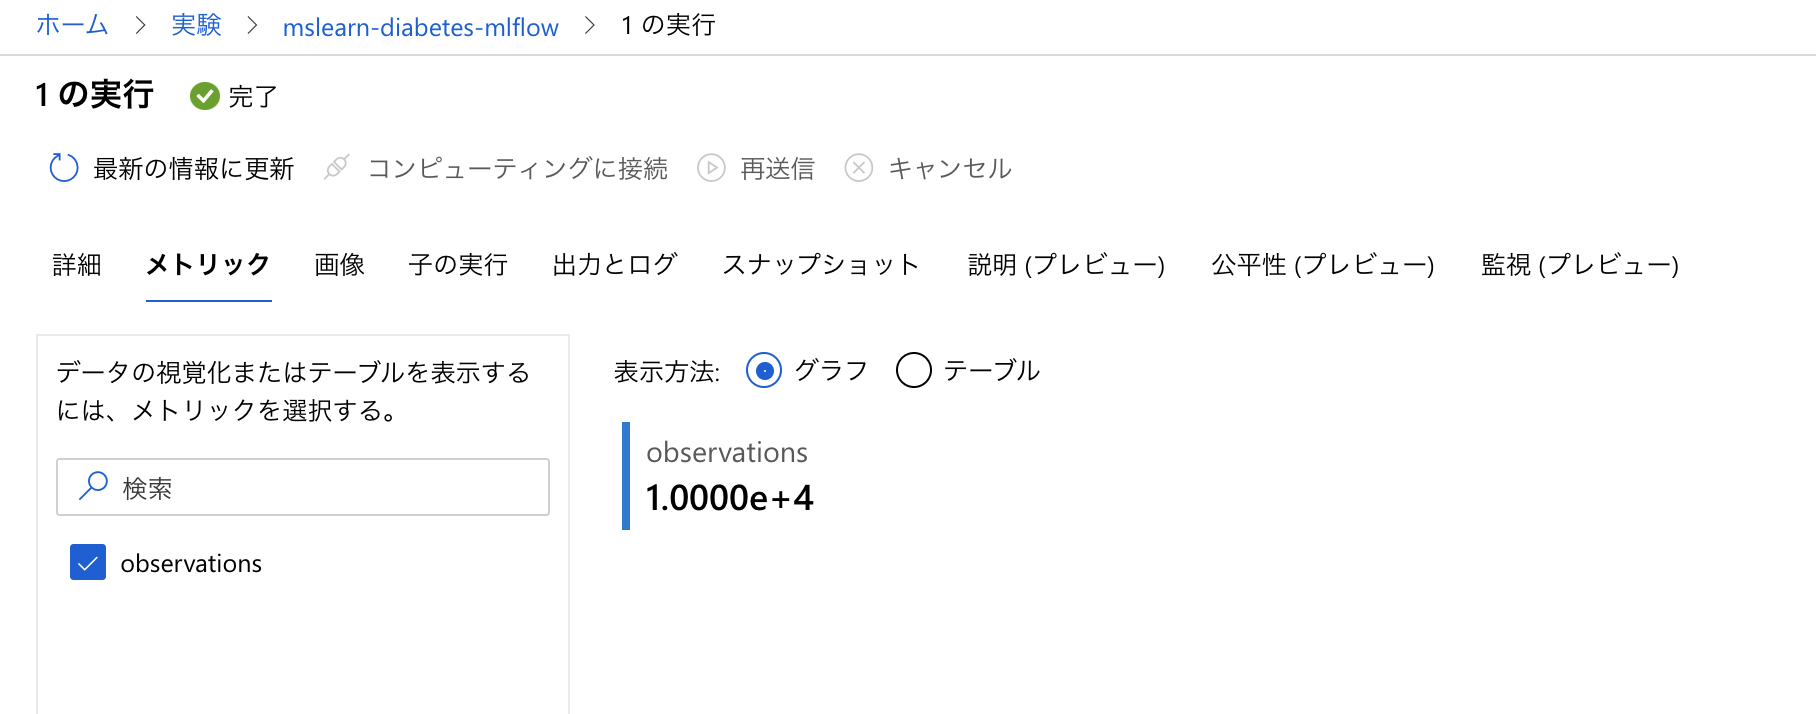

#### 実験スクリプトでMLflowを使用する

MLflowを使用して、実験スクリプトでメトリックを追跡することができる。  
以下の2つのセルを実行して、MLflowを使用する実験用のフォルダとスクリプトを作成する。

In [42]:
import os, shutil

# 実験用ファイル用のフォルダを作成
folder_name = 'mlflow-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# データを実験用フォルダへコピー
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'mlflow-experiment-files/diabetes.csv'

In [43]:
%%writefile $folder_name/mlflow_diabetes.py
from azureml.core import Run
import pandas as pd
import mlflow


# MLflow実験の開始
with mlflow.start_run():
       
    # データの読み込み
    data = pd.read_csv('diabetes.csv')

    # 行数をカウントし、結果をロギング
    row_count = (len(data))
    print('observations:', row_count)
    mlflow.log_metric('observations', row_count)

Writing mlflow-experiment-files/mlflow_diabetes.py


Azure MLの実験スクリプトでMLflowトラッキングを使用すると、実験の実行開始時にMLflowトラッキングのURIが自動的に設定される。  
ただし、スクリプトが実行される環境には、必要な**mlflow**パッケージが含まれている必要がある。

In [44]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

# 実験用のPython環境の作成
mlflow_env = Environment("mlflow-env")

In [45]:
# 必要なパッケージがインストールされていることを確認
packages = CondaDependencies.create(conda_packages=['pandas','pip'],
                                    pip_packages=['mlflow','azureml-mlflow'])
mlflow_env.python.conda_dependencies = packages

In [46]:
# スクリプト構成の作成
script_mlflow = ScriptRunConfig(source_directory=experiment_folder,
                                script='mlflow_diabetes.py',
                                environment=mlflow_env) 

In [47]:
# 実験の実行
experiment = Experiment(workspace=ws, name='mslearn-diabetes-mlflow')
run = experiment.submit(config=script_mlflow)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes-mlflow_1623602241_0a76d58a',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-06-13T16:38:49.780137Z',
 'endTimeUtc': '2021-06-13T16:38:54.126761Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '78124ec0-ad9e-47b8-b14a-840dff389520',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '42570ae33c98ae0cc6919663b3338fc5fb22a16f',
  'mlflow.source.git.commit': '42570ae33c98ae0cc6919663b3338fc5fb22a16f',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'mlflow_diabetes.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataRefer

先程と同様に、実験が終了すると、その実験からログに記録されたメトリックを得ることができる。

In [48]:
# ロギングされたメトリックの取得
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))

observations 10000.0


## 知識チェック

1. Azure Machine Learning について正確に説明している記述は次のうちどれですか?

- Scikit-Learn、PyTorch、Tensorflow のような一般的な機械学習フレームワークの代替として使用できる Python ライブラリ。
- 大規模な機械学習ソリューションを運用するためのクラウドベースのプラットフォーム。
- ドラッグ アンド ドロップ インターフェイスを使用して機械学習モデルを作成できるようにする Microsoft Windows 用のアプリケーション。

2. Azure Machine Learning Python SDK を使用して実験のコードを記述しているとします。  
実験を実行するたびにメトリックをログに記録する必要があります。また、実行ごとにメトリックを簡単に取得できるようにする必要があります。  
何をする必要がありますか?

- 実験コードに print ステートメントを追加してメトリックを出力する。
- 実験データを outputs フォルダーに保存する。
- Run クラスの log* メソッドを使用して名前付きメトリックを記録する。

↓答え

1. 大規模な機械学習ソリューションを運用するためのクラウドベースのプラットフォーム
    - zure Machine Learning を使用すると、機械学習モデルのデータ準備、トレーニング、検証、デプロイを管理できます。  
    Scikit-Learn、PyTorch、Tensorflow などの既存のフレームワークをサポートしており、  
    機械学習をクラウド上で運用できるようにするためのクロスプラットフォームのプラットフォームを提供するものです。

2. Runクラスのlog*メソッドを使用して名前付きメトリックを記録する
    - 実験の実行でメトリックを記録するには、Run.log*メソッドを使用する